# Contour Maps

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapped
from mapped.density import GeoKernelDensity
mapped.__version__, gpd.__version__

('19.12.1', '0.6.2')

Import some random example point data.

In [2]:
from mapped.example_data import mad_points
points = mad_points()
points.head()

,number,letter,geometry
1,73.522015,A,POINT (-9945192.638 5333669.463)
2,59.605820,A,POINT (-9952134.036 5321688.221)
3,52.676887,A,POINT (-9937860.167 5328515.553)
6,22.133990,B,POINT (-9948386.303 5310253.324)
7,34.937765,A,POINT (-9963868.554 5319452.429)


The class `GeoKernelDensity` wraps the more generic scikit-learn `KernelDensity`, providing some 
simplifying default options and features.

In [3]:
from mapped.density import GeoKernelDensity
gkde = GeoKernelDensity(bandwidth=0.00015).fit(points)

One handy feature is the ability to directly output contour plots.

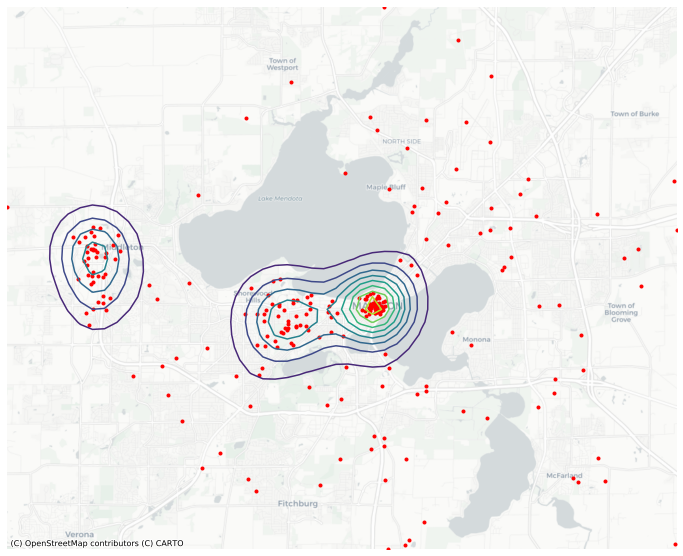

In [4]:
ax = gkde.contour(basemap='CartoDB', figsize=(12,12), levels=10)
points.plot(color='red', marker='.', ax=ax );

The `multifit` fits seperate kernel densities on segments of the data defined by `groupby`.

In [5]:
gkde_m = GeoKernelDensity(bandwidth=0.00015).multifit(points, 'letter')

For example, the demo points contain two classes of point, 'A' and 'B'.

In [6]:
points.groupby('letter').size()

letter
A    174
B     65
dtype: int64

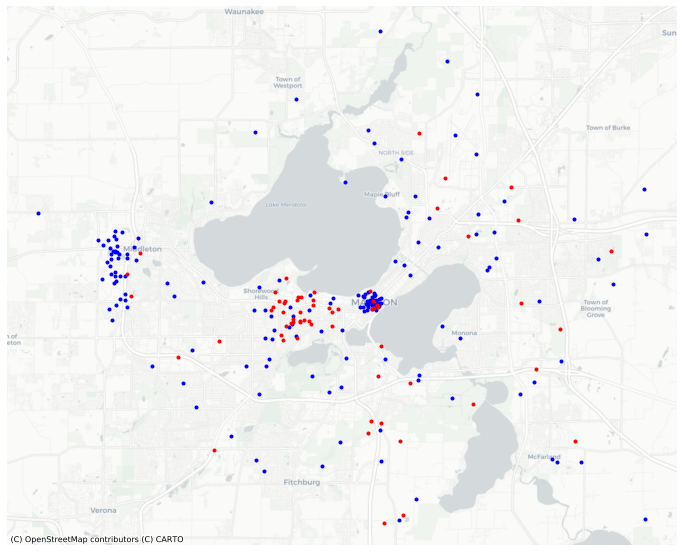

In [7]:
ax = points.query("letter=='A'").plot(color='blue', marker='.', basemap='CartoDB', figsize=(12,12))
points.query("letter=='B'").plot(color='red', marker='.', ax=ax );

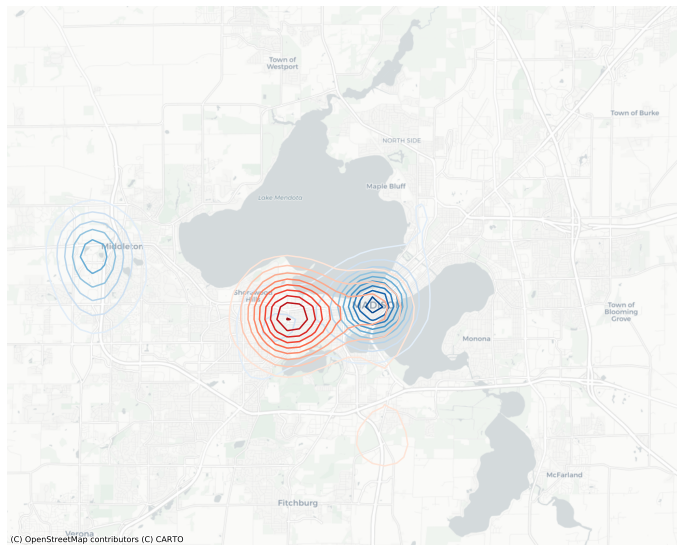

In [8]:
ax = gkde_m['A'].contour(basemap='CartoDB', figsize=(12,12), levels=10, cmap='Blues');
gkde_m['B'].contour(ax=ax, figsize=(12,12), levels=10, cmap='Reds');

The red and blue contours on the plot above have different scales.  To 
harmonize the scales, we need to compute the levels explicitly and pass 
them to the function.  We can also smooth it out my increasing the resolution
from the  default (which is 100).

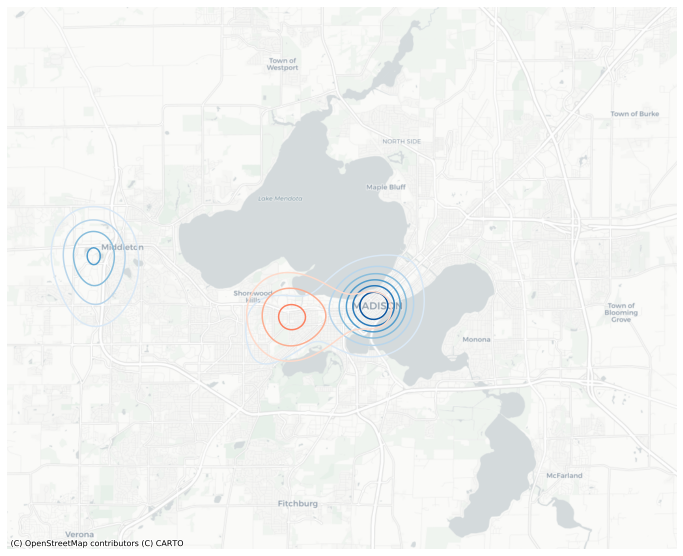

In [9]:
mesh = gkde_m.meshgrid(resolution=300, bounds=points, total='TOT')
levels = np.linspace(0, mesh[['A','B']].values.max(), 8)

ax = mesh.contour('A', basemap='CartoDB', figsize=(12,12), levels=levels, cmap='Blues');
mesh.contour('B', ax=ax, figsize=(12,12), levels=levels, cmap='Reds');

We can mask out lakes if we have a the shape of the lakes.  We can use load those shapes
from the examples (assuming you have OSMnx installed, to get the shapes from OpenStreetMap).

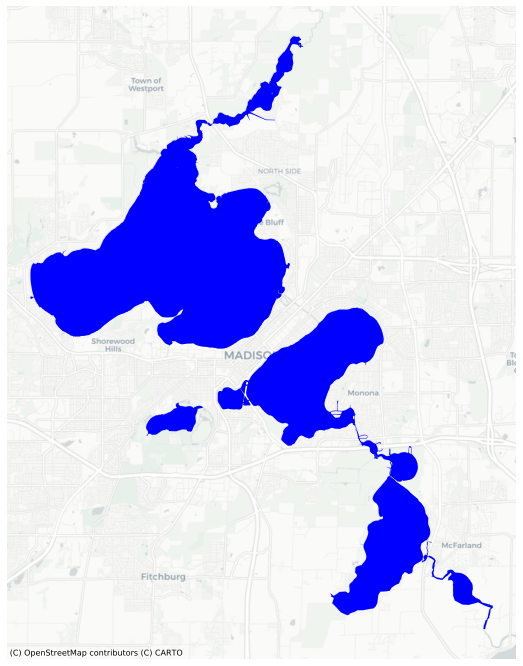

In [10]:
from mapped.example_data import mad_lakes
lakes = mad_lakes()
lakes.plot(basemap='CartoDB', color='blue', figsize=(12,12));

In [11]:
mask = np.ones(len(mesh), dtype=bool)
for lake in lakes.geometry:
    mask &= ~mesh.within(lake)

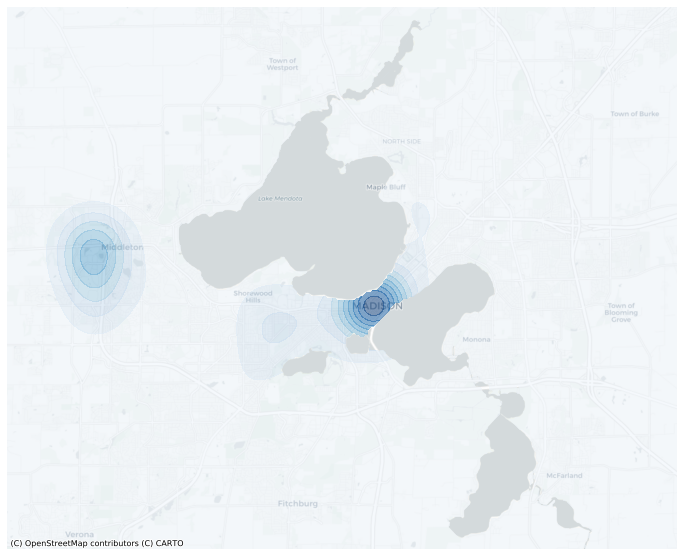

In [12]:
mesh.contour(
    'A', 
    filled=True, 
    alpha=0.5,
    cmap='Blues', 
    basemap='CartoDB', 
    levels=10, 
    figsize=(12,12),
    mask=mask,
);

Plot the relative kernel density of A.

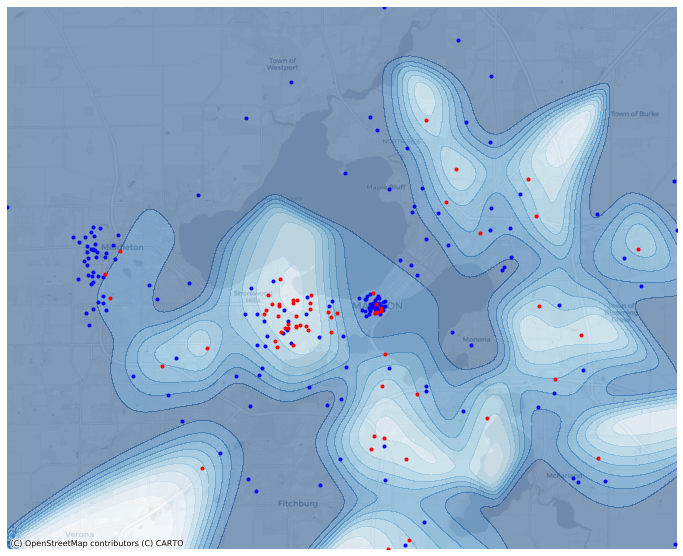

In [13]:
ax = mesh.contour(
    'A/TOT', 
    filled=True, 
    alpha=0.5,
    cmap='Blues', 
    basemap='CartoDB', 
    levels=10, 
    figsize=(12,12),
)

# Also plot the source points by color.
ax = points.query("letter=='A'").plot(ax=ax, color='blue', marker='.')
ax = points.query("letter=='B'").plot(ax=ax, color='red', marker='.');

This is plotting densities across the entire field, but perhaps we only want
to plot the densities on land.  We can use the same mask as before to plot the 
relative kernel density of B, masking lakes.

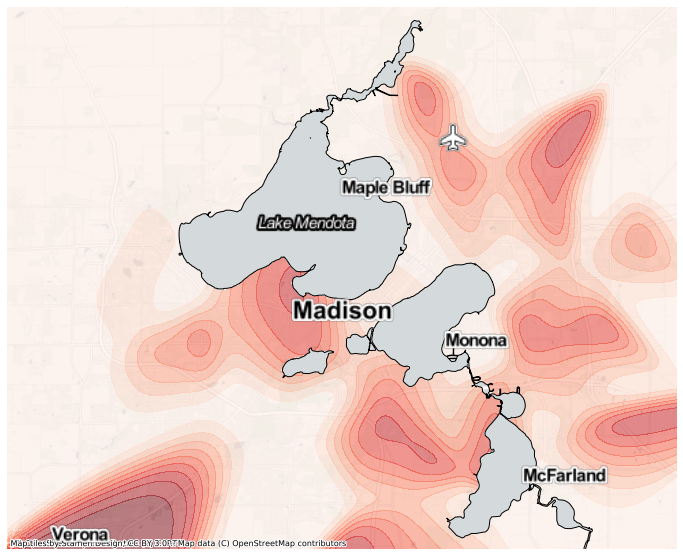

In [14]:
ax = mesh.contour(
    'B/TOT', 
    filled=True, 
    alpha=0.5,
    cmap='Reds', 
    basemap='CartoDB.PositronNoLabels', 
    levels=10, 
    mask=mask,
    figsize=(12,12),
)

# Draw a black border over lakeshores for a cleaner look.
lakes.plot(color="none", edgecolor="black", ax=ax)
mapped.add_basemap(ax=ax, tiles='Stamen.TonerLabels', zoom=11);


You might notice this relative density is a bit noisy, especially around the map edges
where the overall density is quite low.  We can add a prior assumption on the relative
density, that the baseline probability of each letter is proportional to the global
probability, and the observed points are used to measure a deviation from this
prior.  To do so, we can use the `add_prior` function of the `GeoKernelDensities`
object.  Here we take a copy of the original meash

In [15]:
mesh1 = gkde_m.add_prior(mesh, total='TOT')

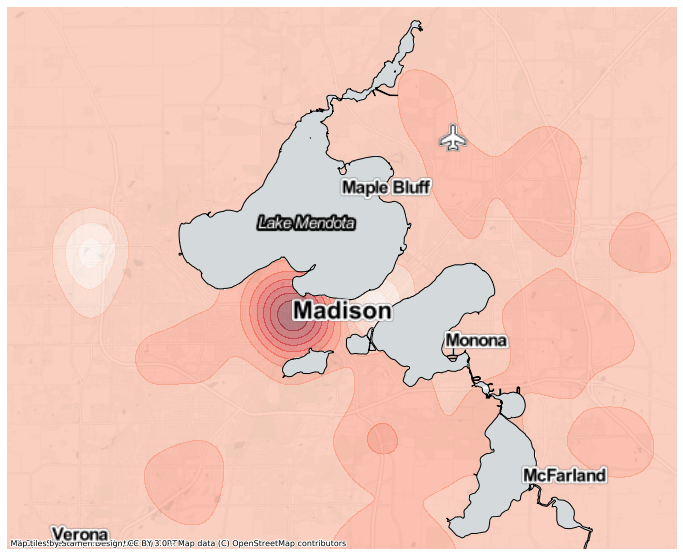

In [16]:
ax = mesh1.contour(
    'B/TOT', 
    filled=True, 
    alpha=0.5,
    cmap='Reds', 
    basemap='CartoDB.PositronNoLabels', 
    levels=10, 
    mask=mask,
    figsize=(12,12),
)

# Draw a black border over lakeshores for a cleaner look.
lakes.plot(color="none", edgecolor="black", ax=ax)
mapped.add_basemap(ax=ax, tiles='Stamen.TonerLabels', zoom=11);


This map doesn't show the relative density of 'B' peaking in Verona, nor bottoming 
out at zero in the other edges.